# **Delta Hedging with SPX Options**

In this approach, we will long an SPX option with a specific delta and one-month maturity. Implied volatility will be used to perform dynamic delta hedging throughout the option's life, with adjustments made continuously until the option expires.

*We will use the VIX to represent implied volatility and the one-month risk-free rate as a substitute for the daily risk-free rate.

In [ ]:
from IPython.display import display

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

# Download VIX data
vix_data = yf.download('^VIX', start="2006-03-01", end="2024-12-20")
print(vix_data.head())

# Download SPX data
spx_ticker = "^GSPC"
spx_data = yf.download(spx_ticker, start="2006-03-01", end="2024-12-20", interval="1d")

[*********************100%***********************]  1 of 1 completed


Price                     Adj Close  Close   High    Low   Open Volume
Ticker                         ^VIX   ^VIX   ^VIX   ^VIX   ^VIX   ^VIX
Date                                                                  
2006-03-01 00:00:00+00:00     11.54  11.54  12.07  11.52  12.05      0
2006-03-02 00:00:00+00:00     11.72  11.72  11.95  11.56  11.79      0
2006-03-03 00:00:00+00:00     11.96  11.96  12.10  11.36  12.03      0
2006-03-06 00:00:00+00:00     12.74  12.74  12.91  12.22  12.22      0
2006-03-07 00:00:00+00:00     12.66  12.66  13.34  12.64  12.92      0


[*********************100%***********************]  1 of 1 completed


In [ ]:
from google.colab import files
uploaded = files.upload()

file_names = list(uploaded.keys())

expiration_data = pd.read_csv(file_names[0])
expiration_data['Expiration'] = pd.to_datetime(expiration_data['Expiration'], format='%m/%d/%y')

rate_data = pd.read_csv(file_names[1])
rate_data['Date'] = pd.to_datetime(rate_data['Date'], format='%m/%d/%y')
rate_data.set_index('Date', inplace=True)
rate_data.rename(columns={'Close': 'Monthly_Rate'}, inplace=True)

Saving expiration.csv to expiration.csv
Saving rates.csv to rates.csv


Now that we have our data, we need to reformat it so that we can use it efficiently. vix_data and spx_data have multilevel indexes. By taking the second level values and retaining only the "Close" column, we create new dataframes that only include the date and closing price of VIX and SPX. We  reset the index to make 'Date' a regular column and then merge the datasets by date.

In [ ]:
# For VIX data
vix_data.columns = vix_data.columns.get_level_values(1)  # Flatten the multi-level columns
vix_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
vix_vol = vix_data[['Close']].copy()  # Extract Close column
vix_vol.index = pd.to_datetime(vix_vol.index).normalize().tz_localize(None)  # Normalize and remove timezone
vix_vol.reset_index(inplace=True)  # Reset the index and add it as a column
vix_vol.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

# For SPX data
spx_data.columns = spx_data.columns.get_level_values(1)
spx_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
spx_data = spx_data[['Close']].copy()  # Extract Close column
spx_data.index = pd.to_datetime(spx_data.index).normalize().tz_localize(None)
spx_data.reset_index(inplace=True)
spx_data.rename(columns={'index': 'Date'}, inplace=True)

backtest_data = pd.merge(spx_data[['Date', 'Close']], vix_vol[['Date', 'Close']], on='Date', suffixes=('_spx', '_vix'))

Then merging our vix and spx data with contract expiration dates and the corresponding monthly risk free rate.

In [ ]:
merged_data = pd.merge_asof(
    backtest_data,
    expiration_data,
    left_on='Date',
    right_on='Expiration',
    direction='forward'
)
merged_data['Monthly_Rate'] = merged_data['Date'].apply(
    lambda x: rate_data.loc[rate_data.index <= x, 'Monthly_Rate'].iloc[-1]
)

In [ ]:
print(merged_data.tail(10))

           Date    Close_spx  Close_vix Expiration  Monthly_Rate
4709 2024-11-13  5965.910156  13.770000 2024-11-22         4.645
4710 2024-11-14  5942.279785  13.590000 2024-11-22         4.645
4711 2024-11-15  5853.009766  14.560000 2024-11-22         4.645
4712 2024-11-18  5865.950195  15.350000 2024-11-22         4.645
4713 2024-11-19  5855.290039  15.370000 2024-11-22         4.645
4714 2024-11-20  5860.560059  16.040001 2024-11-22         4.645
4715 2024-11-21  5887.259766  15.730000 2024-11-22         4.645
4716 2024-11-22  5944.359863  15.240000 2024-11-22         4.645
4717 2024-11-25  5963.910156  14.540000 2024-12-20         4.645
4718 2024-11-26  5992.270020  13.980000 2024-12-20         4.645


We define the Black-Scholes formula as a function:

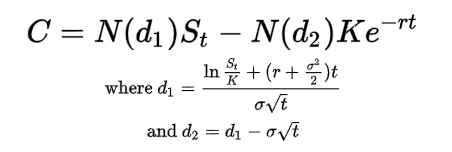

In [ ]:
spx_complete = merged_data
spx_complete['Days_to_Maturity'] = (spx_complete['Expiration'] - spx_complete['Date']).dt.days
spx_complete['T'] = spx_complete['Days_to_Maturity'] / 360


def black_scholes(S, K, T, r, sigma):
    sigma = max(sigma, 1e-6)  # Ensure volatility is not too small
    T = max(T, 1e-6)  # Ensure time to maturity is not zero or too small
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Option price and delta
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

# Calculate option prices and deltas using Black-Scholes
spx_complete[['Option_Price', 'Delta']] = spx_complete.apply(
    lambda row: black_scholes(
        row['Close_spx'],  # S = SPX_Close
        row['Close_spx'],  # K = Strike price for ATM options
        row['T'],  # T = Time to maturity in years
        row['Monthly_Rate'],  # r = Risk-free rate
        row['Close_vix']  # sigma = Implied volatility from the VIX
    ),
    axis=1,
    result_type="expand"
)

To simulate daily pricing and sensitivity (delta) tracking for an at-the-money SPX call option over time, this code calculates the theoretical price and delta of a one-month SPX call option each day using the Black-Scholes model. The strike price is reset at the beginning of each month to be at-the-money (equal to the SPX price), reflecting a strategy where a new option is opened monthly at the current SPX level.

In [ ]:
# Hedging and Transaction costs
Q = 100  # Quantity of options
transaction_cost = 0.0005  # Transaction cost
spx_complete['Hedging_Position'] = -spx_complete['Delta'] * Q
spx_complete['Transaction_Cost'] = transaction_cost * abs(spx_complete['Hedging_Position']) * spx_complete['Close_spx']
spx_complete['Net_Cash_Flow'] = -spx_complete['Hedging_Position'] * spx_complete['Close_spx'] - spx_complete['Transaction_Cost']

# Recalculate daily option price and delta
spx_complete['Daily_Option_Price'] = 0.0
spx_complete['Daily_Delta'] = 0.0
spx_complete['Interest_Accrued'] = 0.0
spx_complete['Portfolio_Value'] = 0.0

# Daily Repricing and Delta Adjustment
for i in range(1, len(spx_complete)):
    current_row = spx_complete.iloc[i]

    # Recalculate option price and delta
    option_price, delta = black_scholes(
        current_row['Close_spx'],
        current_row['Close_spx'],  # ATM strike price
        current_row['T'],
        current_row['Monthly_Rate'],  # Risk-free rate
        current_row['Close_vix']  # Implied volatility
    )

    spx_complete.at[i, 'Daily_Option_Price'] = option_price
    spx_complete.at[i, 'Daily_Delta'] = delta

    # Adjust hedging position
    spx_complete.at[i, 'Hedging_Position'] = -delta * Q

    # Interest accrual
    previous_cash_position = spx_complete.at[i-1, 'Net_Cash_Flow']
    spx_complete.at[i, 'Interest_Accrued'] = previous_cash_position * (current_row['Monthly_Rate'] / 365)

    # Update Portfolio Value
    spx_complete.at[i, 'Portfolio_Value'] = (
        spx_complete.at[i, 'Daily_Option_Price'] * Q +
        previous_cash_position +
        spx_complete.at[i, 'Interest_Accrued']
    )

# Calculate Daily PnL
spx_complete['Daily_PnL'] = spx_complete['Portfolio_Value'].diff()

In [ ]:
print(spx_complete.head())
print(spx_complete.tail())

              Close_spx  Close_vix Expiration  Monthly_Rate  Days_to_Maturity  \
Date                                                                            
2006-03-01  1280.660034      11.52 2006-03-24         4.462                23   
2006-03-02  1283.209961      11.56 2006-03-24         4.462                22   
2006-03-03  1284.199951      11.36 2006-03-24         4.462                21   
2006-03-06  1275.670044      12.22 2006-03-24         4.462                18   
2006-03-07  1271.109985      12.64 2006-03-24         4.462                17   

                   T  Option_Price     Delta  Hedging_Position  \
Date                                                             
2006-03-01  0.063889   1119.670798  0.939886        -93.988557   
2006-03-02  0.061111   1112.350464  0.936280        -93.627969   
2006-03-03  0.058333   1092.944553  0.928773        -92.877335   
2006-03-06  0.050000   1079.979334  0.926175        -92.617541   
2006-03-07  0.047222   1077.405627  

**Delta Dynamics and Hedging Position**
*   The delta generally decreases as the option approaches expiration, reflecting the diminishing sensitivity of the option price to changes in the underlying asset's price. Hedging positions adjust accordingly to maintain the delta neutrality of the portfolio. For example, near expiration, the required number of units in the hedging position decreases significantly.

**Option Price Trends**
*   As expiration approaches, the price tends to drop sharply, nearing zero. This is consistent with the time decay (theta) component of options pricing.

**Portfolio Value and Daily PnL**:

*   Portfolio values show high volatility near expiration. This indicates significant sensitivity to price movements in the underlying asset or rapid adjustments in the hedging strategy.
*   Daily PnL exhibits sharp negative values close to expiration, potentially due to increased transaction costs or inaccuracies in hedging during high volatility.

**Expiration Impact**:

As the time to maturity approaches zero, the portfolio exhibits large swings

*   As the time to maturity approaches zero, the portfolio exhibits large swings in value, emphasizing the importance of rebalancing near expiration to minimize risk exposure.

# Insights:
**Hedging Efficiency**: Effective delta hedging relies on frequent rebalancing, in high-volatility environments or as expiration nears. Transaction costs must be minimized to enhance strategy performance.

**Risk Management**: The strategy's success is highly sensitive to volatility (VIX), as higher implied volatility leads to greater uncertainty in hedging outcomes.

**Future Improvements**: Introducing advanced models like stochastic volatility or incorporating adjustments for transaction costs could improve performance and reduce the impact of daily PnL volatility.


Then calculating our monthly PnL:

In [ ]:
spx_complete['Date'] = pd.to_datetime(spx_complete['Date'])

# Set 'Date' as the index
spx_complete.set_index('Date', inplace=True)

# Calculate Monthly PnL by summing daily PnL for each month
monthly_pnl = spx_complete['Daily_PnL'].resample('ME').sum()

# Reset the index to include 'Date' as a column in the monthly data
monthly_pnl = monthly_pnl.reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

In [ ]:
# Drop the last row from the monthly_pnl DataFrame
monthly_pnl = monthly_pnl.drop(monthly_pnl.tail(1).index)

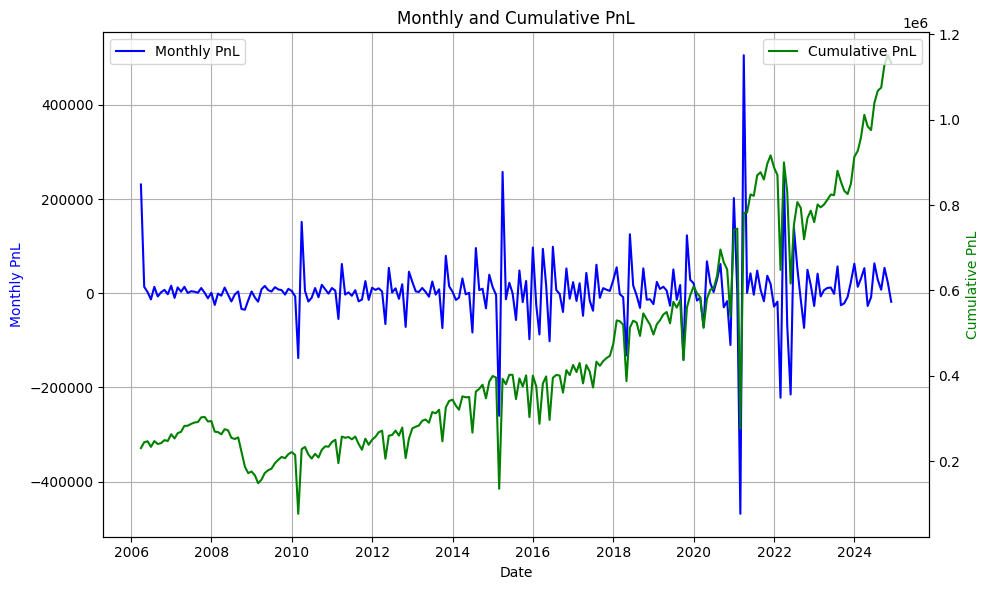

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Monthly PnL on the primary axis
ax1.plot(monthly_pnl['Date'], monthly_pnl['Monthly_PnL'], label='Monthly PnL', color='blue')
ax1.set_title('Monthly and Cumulative PnL')
ax1.set_ylabel('Monthly PnL', color='blue')
ax1.set_xlabel('Date')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for Cumulative PnL
ax2 = ax1.twinx()  # This shares the same x-axis
ax2.plot(monthly_pnl['Date'], monthly_pnl['Cumulative_PnL'], label='Cumulative PnL', color='green')
ax2.set_ylabel('Cumulative PnL', color='green')
ax2.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

plt.show()

## Key Observations

The spikes in **monthly PnL** suggest that the delta hedging strategy is highly responsive to market volatility, as it involves adjusting the underlying asset position frequently in response to changing deltas. This is characteristic of delta hedging, where a trader adjusts positions continuously to mitigate the risk of the option's price changes due to movements in the underlying asset.

Despite the sharp fluctuations in monthly returns, the **cumulative PnL** increases steadily, reflecting the long-term effectiveness of the delta hedging strategy. Over time, the strategy protects the portfolio from large losses and generates positive returns, highlighting its ability to mitigate risk.

The high volatility seen in the monthly PnL is a trade-off between **short-term risk management** (through frequent adjustments) and **long-term stability** (capturing the overall trend of the asset price). While delta hedging is meant to reduce risk, its nature leads to periodic high rewards or losses depending on market movements.


In [ ]:
# Calculate Expected PnL (theoretical under perfect hedge)
spx_complete['Expected_Daily_PnL'] = (
    spx_complete['Daily_Option_Price'].diff() * Q  # Change in option value
    - spx_complete['Daily_Delta'] * spx_complete['Close_spx'].diff() * Q  # Hedge adjustment
)

# Calculate Hedging Error
spx_complete['Hedging_Error'] = spx_complete['Daily_PnL'] - spx_complete['Expected_Daily_PnL']


# Hedging Error Behavior by Delta Ranges

*At-The-Money options rarely have a delta below 0.5

**0.5–0.7 Delta Range:**

A positive mean error suggests that in this range, the hedging strategy slightly overcompensates for price changes, leading to excess gains.
Positive skew indicates that the distribution of hedging errors has a longer right tail, meaning occasional large positive errors.
Kurtosis is close to a normal distribution (kurtosis of 3), indicating relatively few extreme outliers.

**0.7–0.9 Delta Range:**

Lower mean error and standard deviation compared to the previous range suggest more effective hedging. Higher skew indicates more asymmetry, with occasional large positive errors. A slightly elevated kurtosis suggests some tendency for extreme values, but not significantly.


**0.9–1.0 Delta Range:**

The mean error increases slightly compared to the 0.7–0.9 range, possibly reflecting increased transaction costs due to frequent adjustments in the hedge. Median error is significantly lower than the mean, indicating that most errors are smaller, but a few large positive outliers are skewing the mean upward. High skew and kurtosis confirm that this range experiences rare but large positive outliers.

In [ ]:
# Define discrete delta values
discrete_deltas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Assign each delta to the nearest discrete value
spx_complete['Discrete_Delta'] = spx_complete['Daily_Delta'].apply(
    lambda x: min(discrete_deltas, key=lambda y: abs(y - x))
)

# Group by discrete delta values
grouped = spx_complete.groupby('Discrete_Delta')

# Calculate summary statistics
summary_stats = grouped['Hedging_Error'].agg(
    Mean='mean',
    Std_Dev='std',
    Median='median',
    P0=lambda x: np.percentile(x, 0),    # Minimum (0th percentile)
    P25=lambda x: np.percentile(x, 25),  # 25th percentile
    P75=lambda x: np.percentile(x, 75),  # 75th percentile
    P100=lambda x: np.percentile(x, 100),  # Maximum (100th percentile)
    Skewness=skew,
    Kurtosis=kurtosis
).reset_index()

print(summary_stats)

   Discrete_Delta          Mean       Std_Dev        Median             P0  \
0             0.5 -14811.141083   9408.042899 -10434.376225            NaN   
1             0.6  -8962.519318   4298.388148  -7671.533640  -23110.502395   
2             0.7 -10458.143122   7312.606597  -8008.905652  -44750.581304   
3             0.8  -6640.199793   7650.396963  -4369.114892  -41205.644089   
4             0.9   -739.595175  14630.562620  -1645.522059  -35576.642254   
5             1.0   5947.142812  42772.395416   -377.192632 -116499.372770   

            P25          P75           P100  Skewness   Kurtosis  
0           NaN          NaN            NaN       NaN        NaN  
1  -9836.081022 -6383.504008   -3362.757392 -1.642594   2.315488  
2 -14400.143396 -5347.453645    4978.227569 -1.308991   2.328841  
3  -7608.395825 -2062.607186    8761.066013 -2.069794   4.529147  
4  -3792.086425  -201.951849  122016.664143  5.851489  38.946685  
5  -3105.386816  1997.530779  289943.173092  3.1459

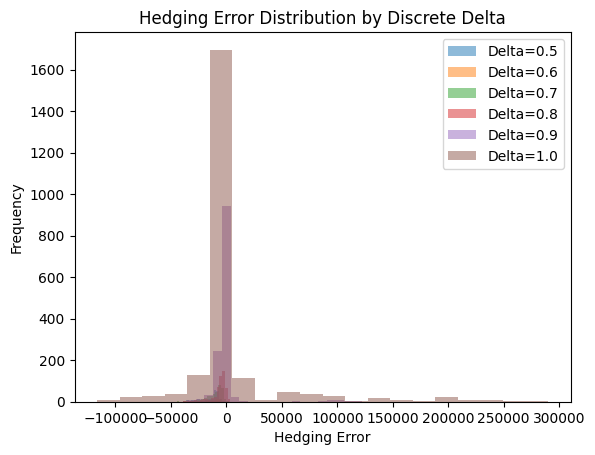

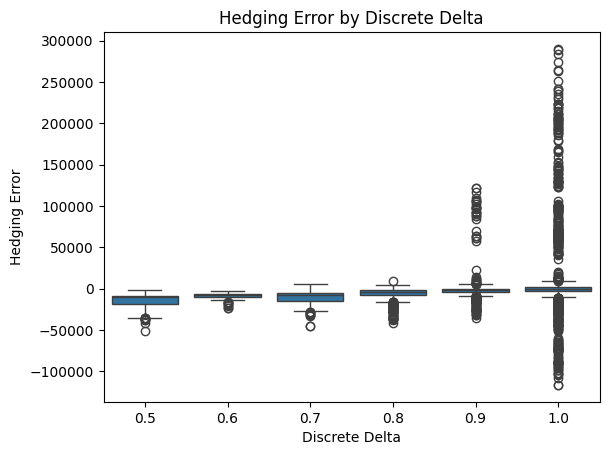

In [ ]:
for delta in discrete_deltas:
    group = spx_complete[spx_complete['Discrete_Delta'] == delta]
    plt.hist(group['Hedging_Error'], bins=20, alpha=0.5, label=f"Delta={delta}")

plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Hedging Error Distribution by Discrete Delta")
plt.show()

sns.boxplot(x='Discrete_Delta', y='Hedging_Error', data=spx_complete)
plt.xlabel("Discrete Delta")
plt.ylabel("Hedging Error")
plt.title("Hedging Error by Discrete Delta")
plt.show()

# Hedging Error by Discrete Delta

1. Histogram Analysis:

The histogram of hedging errors, categorized by discrete delta values shows a high concentration around zero. Most hedging errors are relatively small, with a significant majority clustered close to zero, indicating that the delta hedging strategy generally performs well.
However, There are noticeable outliers in both positive and negative directions, particularly for larger delta values. This suggests occasional significant deviations from the hedged portfolio's expected behavior.

2. Boxplot Analysis:
The boxplot provides further insights into the distribution of hedging errors.

**Delta 0.5 to 0.8:**

*   These deltas exhibit relatively tight interquartile ranges, indicating lower variability in hedging errors. The medians are close to zero, suggesting the strategy achieves its goal of minimizing errors for these delta values. Outliers are present but fewer compared to higher deltas.

**Delta 0.9 and 1.0:**

*   These categories display significantly higher variability, with wider IQRs and more extreme outliers.
For delta = 1, hedging errors are both more positive and more negative, indicating potential issues with over-hedging or model misalignment.
The presence of large positive outliers suggests occasional substantial gains from hedging but also points to higher risk.

As delta approaches 1.0, hedging error distributions become more dispersed. This may be due to higher sensitivity of the hedge to price movements, transaction costs, or the inability of delta to perfectly account for gamma and vega effects. The strategy appears to perform more consistently for lower delta values with fewer extreme hedging errors.


---


Future Work:

- Explore Gamma Risk
- Stress Testing
